In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [34]:
df = pd.read_csv("../datasets/INFY.csv")
df.shape

(18, 83)

In [35]:
closing_prices = df.iloc[0, 1:].values.astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

In [36]:
def create_dataset(df, look_back=20):
    X, Y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:i + look_back, 0])
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [37]:
look_back = 20
X, Y = create_dataset(closing_prices_scaled, look_back)

In [38]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [39]:
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 20, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8951 (34.96 KB)
Trainable params: 8951 (34.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model.fit(X, Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
62/62 - 3s - loss: 0.1390 - 3s/epoch - 52ms/step
Epoch 2/100
62/62 - 0s - loss: 0.0538 - 421ms/epoch - 7ms/step
Epoch 3/100
62/62 - 0s - loss: 0.0230 - 483ms/epoch - 8ms/step
Epoch 4/100
62/62 - 0s - loss: 0.0185 - 454ms/epoch - 7ms/step
Epoch 5/100
62/62 - 0s - loss: 0.0194 - 485ms/epoch - 8ms/step
Epoch 6/100
62/62 - 0s - loss: 0.0123 - 472ms/epoch - 8ms/step
Epoch 7/100
62/62 - 0s - loss: 0.0103 - 420ms/epoch - 7ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0111 - 459ms/epoch - 7ms/step
Epoch 9/100
62/62 - 1s - loss: 0.0065 - 501ms/epoch - 8ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0138 - 479ms/epoch - 8ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0133 - 450ms/epoch - 7ms/step
Epoch 12/100
62/62 - 1s - loss: 0.0076 - 514ms/epoch - 8ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0073 - 467ms/epoch - 8ms/step
Epoch 14/100
62/62 - 1s - loss: 0.0088 - 513ms/epoch - 8ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0102 - 465ms/epoch - 7ms/step
Epoch 16/100
62/62 - 1s - loss: 0.0074 - 507ms/epoc

In [42]:
predicted_closing_prices_scaled = model.predict(X)

predicted_closing_prices = scaler.inverse_transform(predicted_closing_prices_scaled)
actual_closing_prices = scaler.inverse_transform(closing_prices_scaled[look_back:])

2/2 [==============================] - 0s 5ms/step


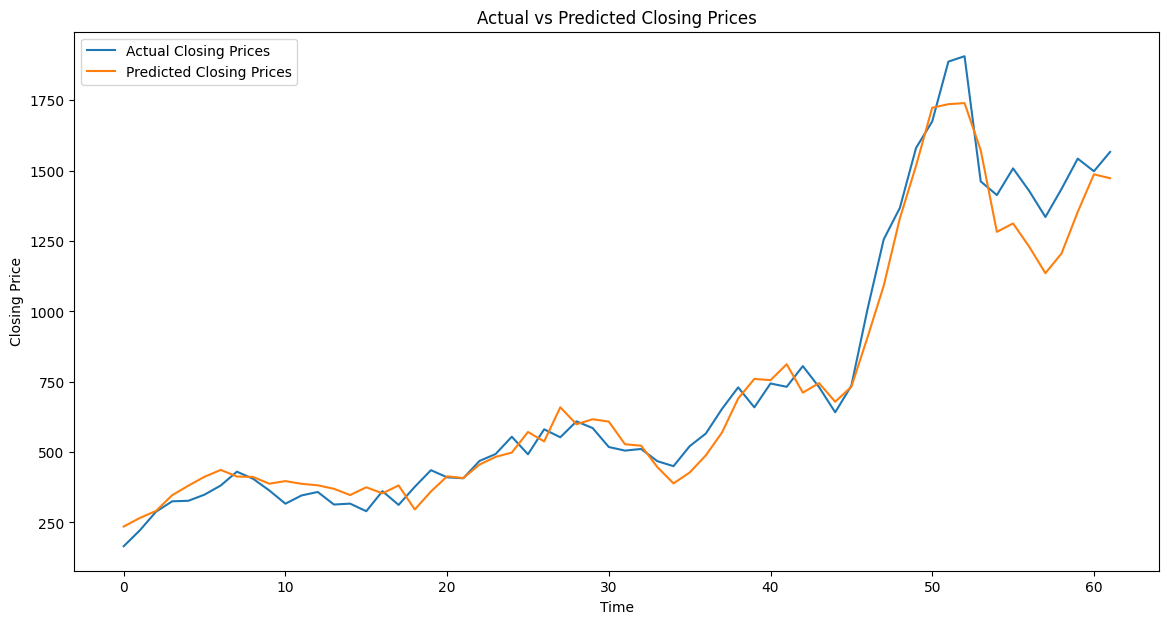

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(actual_closing_prices, label='Actual Closing Prices')
plt.plot(predicted_closing_prices, label='Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [44]:
future_steps = 10
last_sequence = closing_prices_scaled[-look_back:]

future_predictions = []
for _ in range(future_steps):
    next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)[-look_back:].reshape(look_back, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 40ms/step


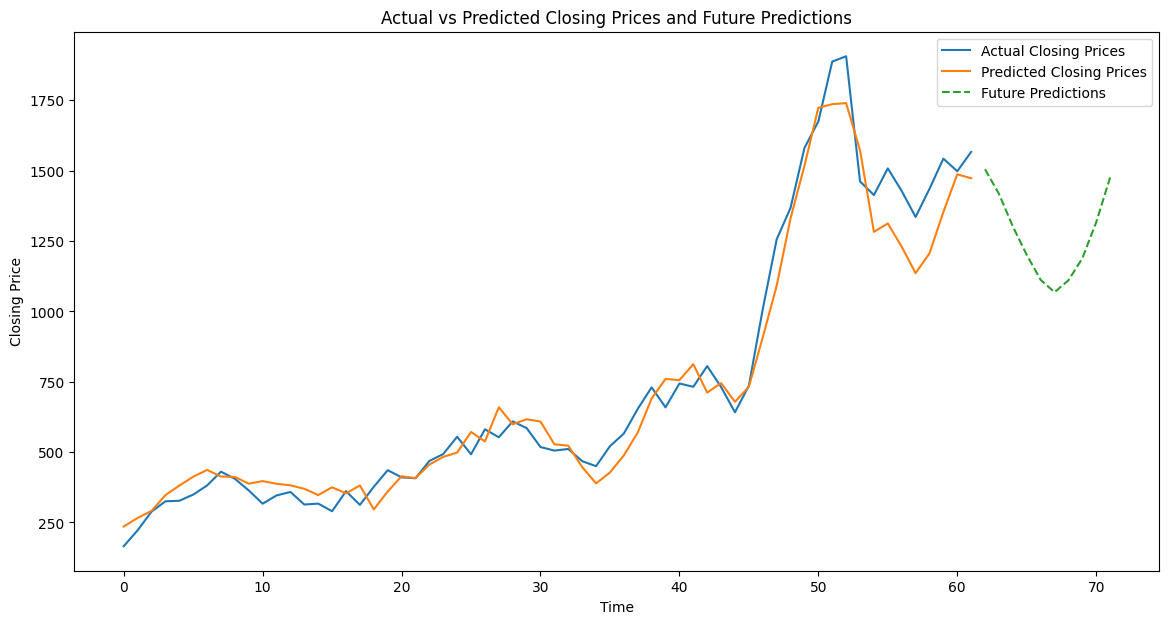

In [45]:
plt.figure(figsize=(14, 7))
plt.plot(actual_closing_prices, label='Actual Closing Prices')
plt.plot(predicted_closing_prices, label='Predicted Closing Prices')
plt.plot(np.arange(len(actual_closing_prices),
                   len(actual_closing_prices) + future_steps), future_predictions, label='Future Predictions', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices and Future Predictions')
plt.legend()
plt.show()

In [46]:
mse = mean_squared_error(actual_closing_prices, predicted_closing_prices)
mae = mean_absolute_error(actual_closing_prices, predicted_closing_prices)
r2 = r2_score(actual_closing_prices, predicted_closing_prices)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 7784.901544383503
MAE: 67.68483783352758
R-squared: 0.96580565786664
